# Preprocess Data

In [1]:
import json
import numpy as np
import cv2
import requests
from PIL import Image
from io import BytesIO
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, Layer, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def extract_pixels_from_url(url):
    # Download the image using requests
    response = requests.get(url)
    if response.status_code != 200:
        print("Failed to download the image.")
        return None

    # Convert the response content to a Bytes stream
    image_data = BytesIO(response.content)

    # Open the image using PIL
    img = Image.open(image_data)

    # Convert the image to RGB (if it's not already)
    img = img.convert('RGB')

    # Get pixel data
    pixels = list(img.getdata())

    return pixels

In [2]:
data = []

# Open NDJSON file from specified path
with open('/content/drive/MyDrive/Data/export-result4.ndjson', 'r') as f:
    # Read and parse each line (JSON object) in the file
    for line in f:
        # Append parsed JSON object to the 'data' list
        data.append(json.loads(line))

# 'data' now contains all JSON objects from the NDJSON file

In [3]:
processed_data = []

# Iterate through each item in the 'data' list
for item in data:
    # Extract image file name, URL, dimensions, and dataset name
    image_file = item['data_row']['external_id']
    image_url = item['data_row']['row_data']
    image_height = item['media_attributes']['height']
    image_width = item['media_attributes']['width']
    original_dataset = item['data_row']['details']['dataset_name']

    # Initialize lists to store objects and classifications in the image
    objects = []
    classifications = []

    # Check if there are labels (annotations) for the current item
    if item['projects']['clna8cr1l0i0107z19feu8tpt']['labels']:
        # Extract object annotations (like bounding boxes and names)
        for x in item['projects']['clna8cr1l0i0107z19feu8tpt']['labels'][0]['annotations']['objects']:
            objects.append((x['name'], x['bounding_box']))

        # Extract classifications (like radio answers or checklist answers)
        for y in item['projects']['clna8cr1l0i0107z19feu8tpt']['labels'][0]['annotations']['classifications']:
            if 'radio_answer' in y:
                classifications.append((y['name'], y['radio_answer']['name']))
            elif 'checklist_answers' in y:
                for z in y['checklist_answers']:
                    classifications.append((y['name'], z['name']))

    # Append the processed information for each image to 'processed_data'
    processed_data.append({
        'image_file': image_file,
        'image_pixels': extract_pixels_from_url(image_url),
        'image_height': image_height,
        'image_width': image_width,
        'original_dataset': original_dataset,
        'objects': objects,
        'classifications': classifications,
    })


In [4]:
train_damage = []
train_no_damage = []
val = []
test = []

# Split processed data into 4 datasets
for item in processed_data:
    if item['original_dataset'] == 'Test':
        test.append(item)
    elif item['original_dataset'] == 'No Damage':
        train_no_damage.append(item)
    elif item['original_dataset'] == 'Train':
        train_damage.append(item)
    elif item['original_dataset'] == 'Validate':
        val.append(item)

# Exterior Damage Localization

In [5]:
# Dictionary mapping specific parts of a vehicle's exterior to numerical classes.
# This is used for categorizing different areas of a vehicle, such as the front end, sides, rear end, etc.
exterior_location_class_map = {
    "Front End (front bumper, hood, front grille, front fenders, front lights, front windshield)": 1,
    "Sides (doors, side mirrors, side fenders, windows, side skirts, pillars)": 2,
    "Rear end (rear bumper, trunk lid, tailgate, rear lights, rear windshield, rear spoiler)": 3,
    "Roof (roof panel, sunroof, roof rails)": 4,
    "Undercarriage (front and rear axles, exhaust system, chassis/frame)": 5,
    "Wheels and tires (alloy rims, wheel covers, tires)": 6
}

# Dictionary mapping types of damage or conditions found on vehicles to numerical classes.
# Useful for categorizing common vehicle damages like dents, scratches, broken glass, etc.
object_class_map = {
    "Dent": 1,
    "Scratch/Scuff/Chip": 2,
    "Broken Glass": 3,
    "Headlight broken": 4,
    "Taillight broken": 5,
    "Smash": 6,
    "Rust": 7,
    "Puncture": 8
}


In [6]:
def preprocess_data(data_list, image_shape=(1024, 1024, 3), obj_classification_map=object_class_map, ext_classification_map=exterior_location_class_map):
    # Initialize lists to store processed images, bounding boxes, and classes.
    images = []
    boxes = []
    box_classes = []
    classifications = []

    for data in data_list:
        # Reshape image pixel data to the specified image shape.
        image = np.array(data['image_pixels']).reshape(data['image_height'], data['image_width'], 3)
        images.append(image)

        bounding_boxes = []
        ext_location = []
        object_classes = []

        # Process each object annotation in the data.
        for obj, box in data['objects']:
            # Normalize bounding box coordinates and append to list.
            normalized_box = [box['top'] / image_shape[0], box['left'] / image_shape[1],
                              (box['top'] + box['height']) / image_shape[0],
                              (box['left'] + box['width']) / image_shape[1]]
            bounding_boxes.append(normalized_box)
            # Map object names to corresponding classes.
            object_classes.append(obj_classification_map.get(obj, -1))

        # Process each classification in the data.
        for category, value in data['classifications']:
            if category == 'Exterior Location':
                # Map exterior location names to corresponding classes.
                ext_location.append(ext_classification_map.get(value, -1))

        # Append processed data to respective lists.
        boxes.append(np.array(bounding_boxes, dtype=np.float64))
        classifications.append(np.array(ext_location))
        box_classes.append(np.array(object_classes))

    # Return arrays of processed images, bounding boxes, box classes, and classifications.
    return np.array(images), np.array(boxes), np.array(box_classes), np.array(classifications)

def pad_classes(input):
    # Convert input to numpy array and ensure each element is a list.
    my_array = np.array([list(item) for item in np.array(input)])

    # Find maximum length of lists in array.
    max_length = max(len(item) for item in my_array)

    # Pad each list in array to maximum length.
    padded_array = np.array([item + [0] * (max_length - len(item)) for item in my_array])

    return padded_array

def pad_boxes(arrays, pad_value=0):
    # Determine maximum dimensions across all arrays.
    max_rows = max(array.shape[0] for array in arrays)
    max_cols = max(array.shape[1] for array in arrays)

    # Pad each array to the maximum dimensions.
    padded_arrays = []
    for array in arrays:
        padding = ((0, max_rows - array.shape[0]),
                   (0, max_cols - array.shape[1]))
        padded_array = np.pad(array, padding, mode='constant', constant_values=pad_value)
        padded_arrays.append(padded_array)

    return padded_arrays


In [7]:
# Preprocess the training data:
train_images, train_boxes, train_box_classes, train_ext_classes = preprocess_data(data_list=train_damage)

# Preprocess the testing data:
test_images, test_boxes, test_box_classes, test_ext_classes = preprocess_data(data_list=test)


<ipython-input-6-8ccf7790fa3e>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(images), np.array(boxes), np.array(box_classes), np.array(classifications)


In [8]:
# Padding datasets so the tensors are the same size
padded_train_boxes = pad_boxes(train_boxes)
padded_train_box_classes = pad_classes(train_box_classes)
padded_train_ext_classes = pad_classes(train_ext_classes)

<ipython-input-6-8ccf7790fa3e>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  my_array = np.array([list(item) for item in np.array(input)])


In [9]:
# Convert the training images to a TensorFlow tensor and normalize pixel values to range [0, 1].
tensor_train_images = tf.convert_to_tensor(train_images) / 255

# Convert the test images to a TensorFlow tensor and normalize pixel values to range [0, 1].
tensor_test_images = tf.convert_to_tensor(test_images) / 255

# Convert the preprocessed and padded training bounding boxes, box classes, and exterior classes to TensorFlow tensors.
tensor_train_boxes = tf.convert_to_tensor(padded_train_boxes)
tensor_train_box_classes = tf.convert_to_tensor(padded_train_box_classes)
tensor_train_ext_classes = tf.convert_to_tensor(padded_train_ext_classes)

# Flatten the train_boxes tensor into a 2D tensor for model input or other processing.
# This changes the shape from [num_samples, num_boxes, box_dimensions] to [num_samples, num_boxes * box_dimensions].
flattened_train_boxes = tf.reshape(tensor_train_boxes, [tensor_train_boxes.shape[0], -1])


In [10]:
def create_model(input_shape=(1024, 1024, 3)):
    # Define the input layer with the specified shape.
    inputs = Input(shape=input_shape)

    # Add convolutional and pooling layers, with dropout for regularization.
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Repeating the pattern of Convolution -> Pooling -> Dropout.
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Flatten the output and pass through dense layers.
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Define output layers for different types of predictions.
    box_classes = Dense(11, activation='softmax', name='box_classes')(x)
    ext_classes = Dense(3, activation='softmax', name='ext_classes')(x)
    boxes = Dense(44, name='boxes')(x)  # Output layer for bounding boxes

    # Assemble the model with the defined layers.
    model = Model(inputs=inputs, outputs=[box_classes, ext_classes, boxes])

    return model

# Instantiate the model
model = create_model()

# Compile the model with appropriate loss functions and metrics for each output.
model.compile(
    optimizer='adam',
    loss={'box_classes': 'categorical_crossentropy',
          'ext_classes': 'categorical_crossentropy',
          'boxes': 'mean_squared_error'},
    metrics={'box_classes': ['accuracy'],
             'ext_classes': ['accuracy'],
             'boxes': ['mean_squared_error']}
)

# Train the model using the preprocessed training data.
history = model.fit(tensor_train_images, [tensor_train_box_classes, tensor_train_ext_classes, flattened_train_boxes],
                    batch_size=16,
                    epochs=10)


Epoch 1/10
4/4 [==============================] - 17s 427ms/step - loss: 6639.2690 - box_classes_loss: 1148.9462 - ext_classes_loss: 85.1444 - boxes_loss: 5405.1782 - box_classes_accuracy: 0.1250 - ext_classes_accuracy: 0.2969 - boxes_mean_squared_error: 5405.1782
Epoch 2/10
4/4 [==============================] - 2s 420ms/step - loss: 213.0968 - box_classes_loss: 126.5160 - ext_classes_loss: 14.7810 - boxes_loss: 71.7999 - box_classes_accuracy: 0.1562 - ext_classes_accuracy: 0.6094 - boxes_mean_squared_error: 71.7999
Epoch 3/10
4/4 [==============================] - 2s 419ms/step - loss: 44.2321 - box_classes_loss: 37.1766 - ext_classes_loss: 1.9123 - boxes_loss: 5.1431 - box_classes_accuracy: 0.1406 - ext_classes_accuracy: 0.7969 - boxes_mean_squared_error: 5.1431
Epoch 4/10
4/4 [==============================] - 2s 415ms/step - loss: 38.7629 - box_classes_loss: 31.9994 - ext_classes_loss: 3.0360 - boxes_loss: 3.7276 - box_classes_accuracy: 0.1719 - ext_classes_accuracy: 0.7969 - boxe

In [11]:
# Save the Model
# model.save('/content/drive/MyDrive/Models/ext_damage_localization_model.keras')

In [12]:
# Display the Model Summary
# model.summary()

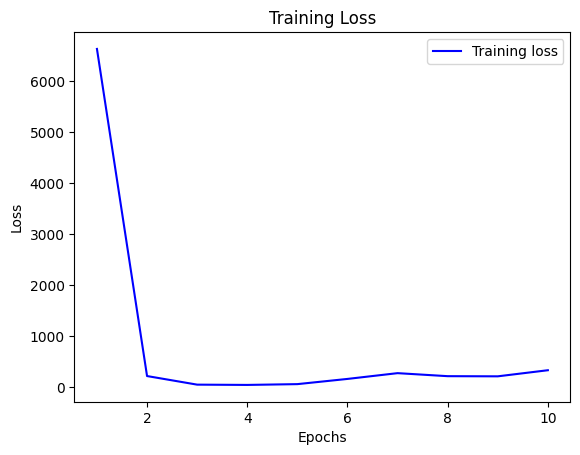

In [13]:
import matplotlib.pyplot as plt

# Assume 'history' is the object returned by the 'fit' method of your model
loss = history.history['loss']

epochs = range(1, len(loss) + 1)

# Plot training and validation loss as lines
plt.figure()
plt.plot(epochs, loss, 'b-', label='Training loss')  # 'b-' gives blue color with solid line
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Exterior Damage Severity

In [5]:
# Define class map for severity
severity_class_map = {
    'No Damage': 0,
    'Minor Damage': 1,
    'Moderate Damage': 2,
    'Major Damage': 3,
    'Totaled': 4
}

In [6]:
def preprocess_data(data_list, image_shape=(1024, 1024, 3), severity_classification_map=severity_class_map):
    # Initialize lists for storing processed images and classifications.
    images = []
    classifications = []

    # Loop through each item in the data list.
    for data in data_list:
        # Convert image pixel data to numpy array and reshape according to specified image shape.
        image = np.array(data['image_pixels']).reshape(data['image_height'], data['image_width'], 3)
        images.append(image)  # Add processed image to the images list.

        ext_severity = []  # List to store severity classifications.

        # Process classifications in the data.
        for classification, value in data['classifications']:
            # Check for 'Exterior Damage Severity' classification and map its value.
            if classification == 'Exterior Damage Severity':
                ext_severity.append(severity_class_map.get(value, 0))

        # Append processed severity classifications to the classifications list.
        classifications.append(np.array(ext_severity))

    # Return the processed images and classifications as numpy arrays.
    return np.array(images), np.array(classifications)


In [7]:
# Process training data using the 'preprocess_data' function to get images and exterior severity classes.
train_images, train_ext_sev_classes = preprocess_data(data_list=train_damage)

# Process testing data using the same function to get images and exterior severity classes.
test_images, test_ext_sev_classes = preprocess_data(data_list=test)

# Convert the training images to TensorFlow tensors and normalize their pixel values to the range [0, 1].
tensor_train_images = tf.convert_to_tensor(train_images) / 255

# Convert the testing images to TensorFlow tensors and normalize their pixel values to the range [0, 1].
tensor_test_images = tf.convert_to_tensor(test_images) / 255

# Convert the training exterior severity classes to TensorFlow tensors.
tensor_train_ext_sev_classes = tf.convert_to_tensor(train_ext_sev_classes)


In [8]:
def create_severity_model(input_shape=(1024, 1024, 3)):
    # Define the input layer of the model with the specified shape.
    input_tensor = Input(shape=input_shape)

    # Add convolutional layers with MaxPooling and ReLU activation.
    x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)

    # Flatten the output and pass it through dense layers.
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    # Final output layer with softmax activation for classification.
    output = Dense(5, activation='softmax')(x)

    # Create the model object with input and output configurations.
    model = Model(inputs=input_tensor, outputs=output)

    return model

# Create the severity model instance.
ext_severity_model = create_severity_model()

# Compile the model with Adam optimizer, categorical crossentropy loss, and track accuracy.
ext_severity_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with the training images and their corresponding severity classes.
history = ext_severity_model.fit(
    tensor_train_images,
    tensor_train_ext_sev_classes,
    epochs=10,        # Specifies the number of training epochs.
    batch_size=16,    # Specifies the batch size for training.
)


Epoch 1/10
4/4 [==============================] - 14s 254ms/step - loss: 29.3241 - accuracy: 0.4531
Epoch 2/10
4/4 [==============================] - 1s 255ms/step - loss: 3.4285 - accuracy: 0.5625
Epoch 3/10
4/4 [==============================] - 1s 253ms/step - loss: 1.4716 - accuracy: 0.4844
Epoch 4/10
4/4 [==============================] - 1s 252ms/step - loss: 0.7992 - accuracy: 0.7031
Epoch 5/10
4/4 [==============================] - 1s 254ms/step - loss: 0.9440 - accuracy: 0.7188
Epoch 6/10
4/4 [==============================] - 1s 256ms/step - loss: 0.5527 - accuracy: 0.9062
Epoch 7/10
4/4 [==============================] - 1s 254ms/step - loss: 0.3657 - accuracy: 0.8750
Epoch 8/10
4/4 [==============================] - 1s 252ms/step - loss: 0.1996 - accuracy: 0.9531
Epoch 9/10
4/4 [==============================] - 1s 251ms/step - loss: 0.0935 - accuracy: 0.9688
Epoch 10/10
4/4 [==============================] - 1s 251ms/step - loss: 0.1397 - accuracy: 0.9531


In [9]:
# Save the Model
# ext_severity_model.save('/content/drive/MyDrive/Models/ext_damage_severity_model.keras')

In [10]:
# Display Model Summary
# ext_severity_model.summary()

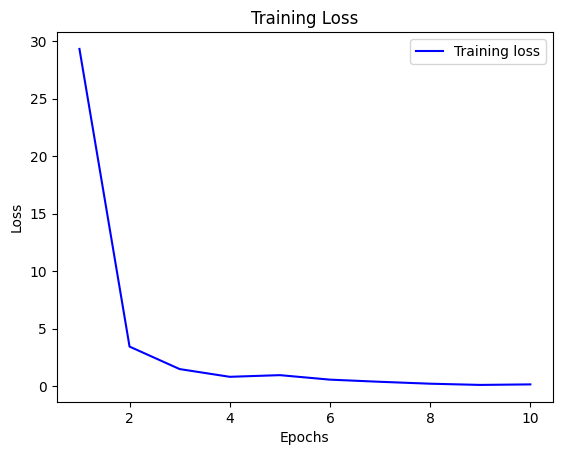

In [11]:
import matplotlib.pyplot as plt

# Assume 'history' is the object returned by the 'fit' method of your model
loss = history.history['loss']


epochs = range(1, len(loss) + 1)

# Plot training and validation loss as lines
plt.figure()
plt.plot(epochs, loss, 'b-', label='Training loss')  # 'b-' gives blue color with solid line
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Interior Damage Location and Severity

In [5]:
# Define class maps for severity, exterior location, and interior regions affected
int_sev_class_map = {
    'No Damage': 0,
    'Minor Damage': 1,
    'Moderate Damage': 2,
    'Major Damage': 3,
    'Totaled': 4
}

interior_regions_class_map = {
    'Dashboard Area (Instrument panel, center console, globe compartment)': 1,
    'Front Area (driver\'s seat, passenger seat, gear shift, pedals, steering wheel and column, footwells)': 2,
    'Middle Area (rear seats, center armrest, floor console)': 3,
    'Storage and Utility (door pockets, cup holders, rear parcel shelf, boot/trunk)': 4,
    'Roof Area ( sun visors, rearview mirror, sunroof, roof lining, grab handles)': 5,
    'Rear area (backseat pockets, rear air vents, rear center console)': 6,
    'Miscellaneous (lighting, ports and outlets, controls)': 7,
    'Engine compartment (engine, radiator, battery, air filter, fuse box)': 8,
    'Transmission and Drivetrain (transmission, drive shaft, differential, axles)': 9,
    'Exhaust system (exhaust manifold, catalytic converter, muffler, exhaust pipe)': 10,
    'Fuel System (fuel tank, fuel pump, fuel injectors)': 11,
    'Brake system (brake pedal, master cylinder, brake pads, rotors, brake calipers)': 12,
    'Suspension and steering (shock absorbers/struts, springs, control arms, steering rack and pinion)': 13,
    'electrical system (alternator, starter motor, wiring harness)': 14,
    'climate system (air conditioning compressor, heater core, blower motor)': 15,
    'Body and frame (chasis, frame, body panels)': 16
}

In [6]:
def preprocess_data(data_list, image_shape=(1024, 1024, 3), int_sev_map=int_sev_class_map, int_classification_map=interior_regions_class_map):
    # Initialize lists to store images and their associated classifications.
    images = []
    sev_classes = []  # Severity classes.
    classifications = []  # Interior region classifications.

    # Iterate through each data item in the provided list.
    for data in data_list:
        # Reshape image data and append to the images list.
        image = np.array(data['image_pixels']).reshape(data['image_height'], data['image_width'], 3)
        images.append(image)

        int_sev = []  # List for storing interior severity classifications.
        int_location = []  # List for storing interior location classifications.

        # Process each classification in the data.
        for category, value in data['classifications']:
            # Map interior region classification to its corresponding integer value.
            if category == 'Potential Interior Regions Affected':
                int_location.append(int_classification_map.get(value, -1))

        # Map interior damage severity to its corresponding integer value.
        for classification, value in data['classifications']:
            if classification == 'Interior Damage Severity':
                int_sev.append(int_sev_map.get(value, 0))

        # Append processed classifications to respective lists.
        classifications.append(np.array(int_location))
        sev_classes.append(np.array(int_sev))

    # Return the processed images, severity classes, and classifications as numpy arrays.
    return np.array(images), np.array(sev_classes), np.array(classifications)

def pad_classes(input):
    # Convert the input list to a numpy array ensuring each element is a list.
    my_array = np.array([list(item) for item in np.array(input)])

    # Determine the maximum length among the lists.
    max_length = max(len(item) for item in my_array)

    # Pad each list in the array to the maximum length with zeros.
    padded_array = np.array([item + [0] * (max_length - len(item)) for item in my_array])

    return padded_array


In [7]:
# Process the training and test datasets using the 'preprocess_data' function.
# This extracts images, interior severity classes, and interior locations.
train_images, train_int_sev_classes, train_int_locations = preprocess_data(data_list=train_damage)
test_images, test_int_sev_classes, test_int_locations = preprocess_data(data_list=test)

# Pad the training interior location data for uniformity in tensor size.
padded_train_int_locations = pad_classes(train_int_locations)

# Convert the training and test images into TensorFlow tensors and normalize them.
tensor_train_images = tf.convert_to_tensor(train_images) / 255
tensor_test_images = tf.convert_to_tensor(test_images) / 255

# Convert the training interior severity classes to one-hot encoded format.
train_int_sev_classes_one_hot = to_categorical(train_int_sev_classes, num_classes=5)

# Convert the padded training interior location classes to a TensorFlow tensor.
tensor_train_int_classes = tf.convert_to_tensor(padded_train_int_locations)


<ipython-input-6-6c40cbdac61a>:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(images), np.array(sev_classes), np.array(classifications)
<ipython-input-6-6c40cbdac61a>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  my_array = np.array([list(item) for item in np.array(input)])


In [8]:
def transform_to_binary_matrix(labels, num_classes=16):
    # Initialize a matrix of zeros with a shape based on the number of labels and the number of classes.
    binary_matrix = np.zeros((len(labels), num_classes))

    # Iterate over each set of labels in the provided labels list.
    for i, label_set in enumerate(labels):
        # Iterate through each label in the current set of labels.
        for label in label_set:
            # Check if label is greater than 0 (assuming 0 means 'no class').
            if label > 0:
                # Set the corresponding position in the matrix to 1.
                # Adjust index by subtracting 1 as classes are 1-indexed.
                binary_matrix[i, label - 1] = 1

    # Return the binary matrix representing the label data.
    return binary_matrix

# Apply the function to transform the training and test interior location data into binary matrices.
train_int_locations_binary = transform_to_binary_matrix(train_int_locations)
test_int_locations_binary = transform_to_binary_matrix(test_int_locations)


In [9]:
def create_model(input_shape=(1024, 1024, 3)):
    # Define the input layer of the model with the specified shape.
    inputs = Input(shape=input_shape)

    # Add convolutional layers with MaxPooling and ReLU activation.
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Repeating the pattern of Convolution -> Pooling -> ReLU activation.
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten the output and add a dense layer with ReLU activation.
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)

    # Define output layers for severity and interior class predictions.
    sev_classes = Dense(5, activation='softmax', name='sev_classes')(x)
    int_classes = Dense(16, activation='sigmoid', name='int_classes')(x)

    # Create the model with inputs and the two outputs.
    model = Model(inputs=inputs, outputs=[sev_classes, int_classes])

    return model

# Instantiate and compile the model with specific loss functions for each output.
model = create_model()
model.compile(
    optimizer='adam',
    loss={'sev_classes': 'categorical_crossentropy',  # Loss function for severity classes.
          'int_classes': 'binary_crossentropy'},     # Loss function for interior classes.
    metrics={'sev_classes': ['accuracy'],            # Metrics to monitor for severity classes.
             'int_classes': ['accuracy']}            # Metrics to monitor for interior classes.
)

# Train the model using the training images and their corresponding class labels.
history = model.fit(
    tensor_train_images,
    [train_int_sev_classes_one_hot, train_int_locations_binary],  # Training targets.
    batch_size=16,  # Size of the batches of data.
    epochs=10       # Number of training epochs.
)


Epoch 1/10
4/4 [==============================] - 14s 253ms/step - loss: 40.0143 - sev_classes_loss: 36.2384 - int_classes_loss: 3.7759 - sev_classes_accuracy: 0.3281 - int_classes_accuracy: 0.1875
Epoch 2/10
4/4 [==============================] - 1s 254ms/step - loss: 3.9901 - sev_classes_loss: 3.4032 - int_classes_loss: 0.5869 - sev_classes_accuracy: 0.3750 - int_classes_accuracy: 0.2812
Epoch 3/10
4/4 [==============================] - 1s 252ms/step - loss: 1.4316 - sev_classes_loss: 1.0064 - int_classes_loss: 0.4252 - sev_classes_accuracy: 0.5938 - int_classes_accuracy: 0.2969
Epoch 4/10
4/4 [==============================] - 1s 257ms/step - loss: 1.1304 - sev_classes_loss: 0.8389 - int_classes_loss: 0.2915 - sev_classes_accuracy: 0.6875 - int_classes_accuracy: 0.3906
Epoch 5/10
4/4 [==============================] - 1s 252ms/step - loss: 0.5493 - sev_classes_loss: 0.2928 - int_classes_loss: 0.2565 - sev_classes_accuracy: 0.9062 - int_classes_accuracy: 0.3906
Epoch 6/10
4/4 [======

In [10]:
# Save Model
# model.save('/content/drive/MyDrive/Models/int_damage_and_severity_model.keras')

In [11]:
# Display Model Summary
# model.summary()

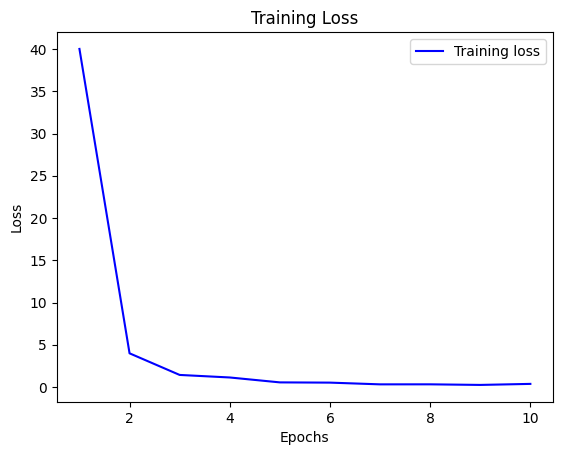

In [12]:
import matplotlib.pyplot as plt

# Assume 'history' is the object returned by the 'fit' method of your model
loss = history.history['loss']

epochs = range(1, len(loss) + 1)

# Plot training and validation loss as lines
plt.figure()
plt.plot(epochs, loss, 'b-', label='Training loss')  # 'b-' gives blue color with solid line
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
